In [1]:
from google.colab import files
uploaded = files.upload()

Saving weatherHistory.csv to weatherHistory.csv


**PART A**

In [3]:
# ===============================
# Part A: Data Understanding and Preprocessing
# ===============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# -------------------------------
# 1. Load dataset
# -------------------------------
df = pd.read_csv("weatherHistory.csv")

# Display first 10 rows
print("First 10 rows:")
print(df.head(10))

First 10 rows:
                  Formatted Date        Summary Precip Type  Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain         9.472222   
1  2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain         9.355556   
2  2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain         9.377778   
3  2006-04-01 03:00:00.000 +0200  Partly Cloudy        rain         8.288889   
4  2006-04-01 04:00:00.000 +0200  Mostly Cloudy        rain         8.755556   
5  2006-04-01 05:00:00.000 +0200  Partly Cloudy        rain         9.222222   
6  2006-04-01 06:00:00.000 +0200  Partly Cloudy        rain         7.733333   
7  2006-04-01 07:00:00.000 +0200  Partly Cloudy        rain         8.772222   
8  2006-04-01 08:00:00.000 +0200  Partly Cloudy        rain        10.822222   
9  2006-04-01 09:00:00.000 +0200  Partly Cloudy        rain        13.772222   

   Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  7.388889      0.89       

In [4]:
# -------------------------------
# 2. Convert date column & sort
# -------------------------------
df["Formatted Date"] = pd.to_datetime(df["Formatted Date"], utc=True)
df = df.sort_values("Formatted Date").reset_index(drop=True)


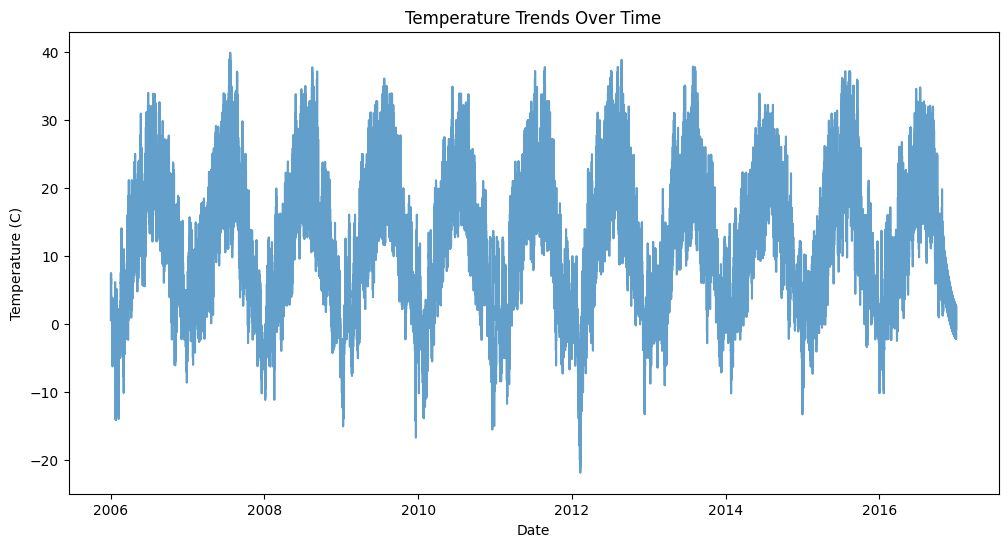

In [5]:
# -------------------------------
# 3. Plot temperature trends
# -------------------------------
plt.figure(figsize=(12,6))
plt.plot(df["Formatted Date"], df["Temperature (C)"], alpha=0.7)
plt.title("Temperature Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Temperature (C)")
plt.show()


In [6]:
# -------------------------------
# 4. Check missing values
# -------------------------------
print("\nMissing values per column:")
print(df.isnull().sum())



Missing values per column:
Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64


In [7]:
# -------------------------------
# 5. Handle missing values
# -------------------------------
# Option: forward-fill, then drop remaining NaN
df = df.fillna(method="ffill").dropna()

/tmp/ipython-input-1374124703.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").dropna()


In [8]:
# -------------------------------
# 6. Select features
# -------------------------------
features = ["Temperature (C)", "Humidity", "Wind Speed (km/h)"]
data = df[features].values

In [9]:
# -------------------------------
# 7. Normalize values
# -------------------------------
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [10]:
# -------------------------------
# 8. Create input sequences
# -------------------------------
def create_sequences(dataset, window_size=14):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i+window_size, :])       # past 14 days
        y.append(dataset[i+window_size, 0])         # next day temp
    return np.array(X), np.array(y)

window_size = 14   # you can also try 7
X, y = create_sequences(scaled_data, window_size)

print(f"\nShape of input sequences: {X.shape}")
print(f"Shape of targets: {y.shape}")



Shape of input sequences: (96439, 14, 3)
Shape of targets: (96439,)


In [11]:
# -------------------------------
# 9. Train / Validation / Test split
# -------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, shuffle=False)  # keep time order

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, shuffle=False)

print("\nDataset shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Dataset shapes:
Train: (67507, 14, 3) (67507,)
Validation: (14466, 14, 3) (14466,)
Test: (14466, 14, 3) (14466,)


**PART B**

In [12]:
# ===============================
# Part B: RNN Model Development
# ===============================

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

In [13]:
# -------------------------------
# 1. Build the model
# -------------------------------
model = Sequential([
    SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),  # optional, helps reduce overfitting
    Dense(1)       # linear output for regression
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# -------------------------------
# 2. Compile the model
# -------------------------------
model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["mae"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417 (17.25 KB)

 Trainable params: 4,417 (17.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# -------------------------------
# 3. Train the model
# -------------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,             # you can increase to 100
    batch_size=32,
    verbose=1
)

Epoch 1/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0117 - mae: 0.0675 - val_loss: 4.5348e-04 - val_mae: 0.0170
Epoch 2/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0015 - mae: 0.0298 - val_loss: 4.0116e-04 - val_mae: 0.0156
Epoch 3/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 9.0862e-04 - mae: 0.0228 - val_loss: 3.0501e-04 - val_mae: 0.0132
Epoch 4/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 6.7267e-04 - mae: 0.0195 - val_loss: 2.8131e-04 - val_mae: 0.0126
Epoch 5/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 6.0974e-04 - mae: 0.0184 - val_loss: 2.7384e-04 - val_mae: 0.0128
Epoch 6/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 5.8113e-04 - mae: 0.0179 - val_loss: 2.9302e-04 - val_mae: 0.0134
Epoch 7/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 5.7919e-04 - mae: 0.0178 - val_loss: 3.1317e-04 - val_mae: 0.0129
Epoch 8/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 5.5462e-04 - mae: 0.0174 - val_loss: 2.7026

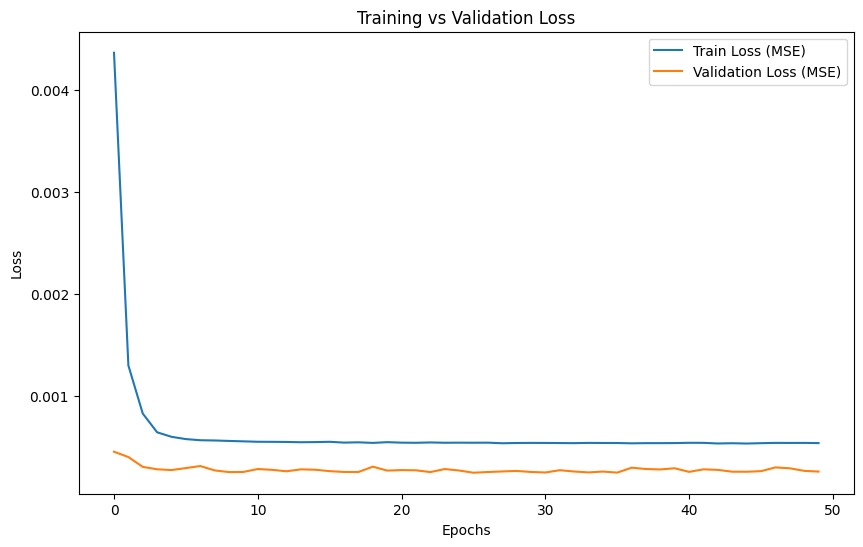

In [16]:
# -------------------------------
# 4. Plot training vs validation loss
# -------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(history.history["loss"], label="Train Loss (MSE)")
plt.plot(history.history["val_loss"], label="Validation Loss (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

**PART C**

In [17]:
# ===============================
# Part C: Model Evaluation & Forecasting
# ===============================

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------------
# 1. Evaluate on test set
# -------------------------------
y_pred = model.predict(X_test)

# Convert back to original scale (only temperature column)
# y and predictions were scaled → we need to inverse transform
temp_scaler = MinMaxScaler()
temp_scaler.min_, temp_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

y_test_rescaled = (y_test - temp_scaler.min_) / temp_scaler.scale_
y_pred_rescaled = (y_pred.flatten() - temp_scaler.min_) / temp_scaler.scale_

# Metrics
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test R²:   {r2:.4f}")


453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test RMSE: 0.9692
Test MAE:  0.7344
Test R²:   0.9890


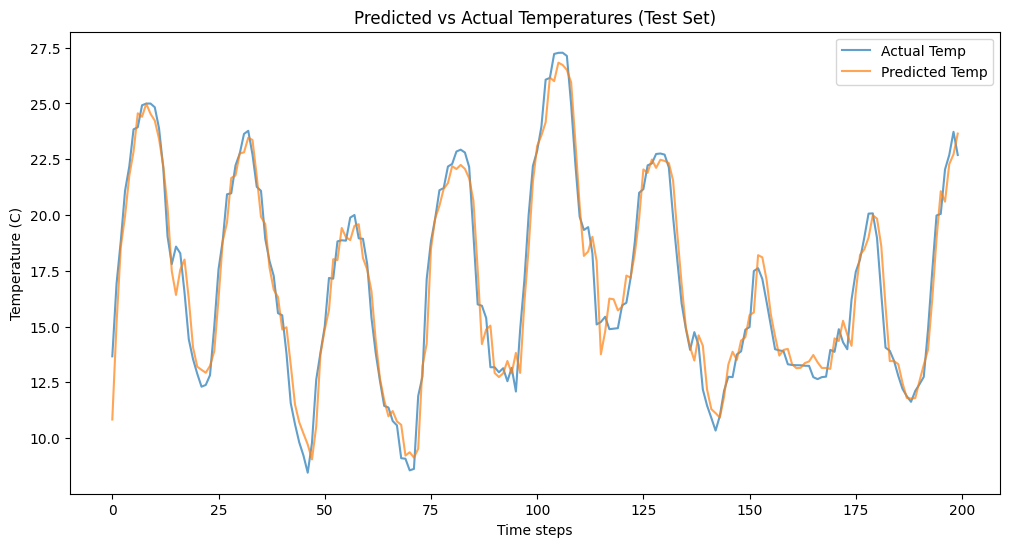

In [18]:
# -------------------------------
# 2. Plot predicted vs actual
# -------------------------------
plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled[:200], label="Actual Temp", alpha=0.7)  # first 200 for visibility
plt.plot(y_pred_rescaled[:200], label="Predicted Temp", alpha=0.7)
plt.title("Predicted vs Actual Temperatures (Test Set)")
plt.xlabel("Time steps")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()


In [19]:
# -------------------------------
# 3. Forecast next 7 days
# -------------------------------
last_sequence = X_test[-1]  # take the last sequence from test set
forecast = []

current_seq = last_sequence

for _ in range(7):  # next 7 days
    pred = model.predict(current_seq[np.newaxis, :, :])[0,0]

    # Append prediction
    forecast.append(pred)

    # Update sequence → drop first, append new prediction
    new_seq = np.append(current_seq[1:], [[pred, current_seq[-1,1], current_seq[-1,2]]], axis=0)
    current_seq = new_seq

# Rescale forecasted values back to Celsius
forecast_rescaled = (np.array(forecast) - temp_scaler.min_) / temp_scaler.scale_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


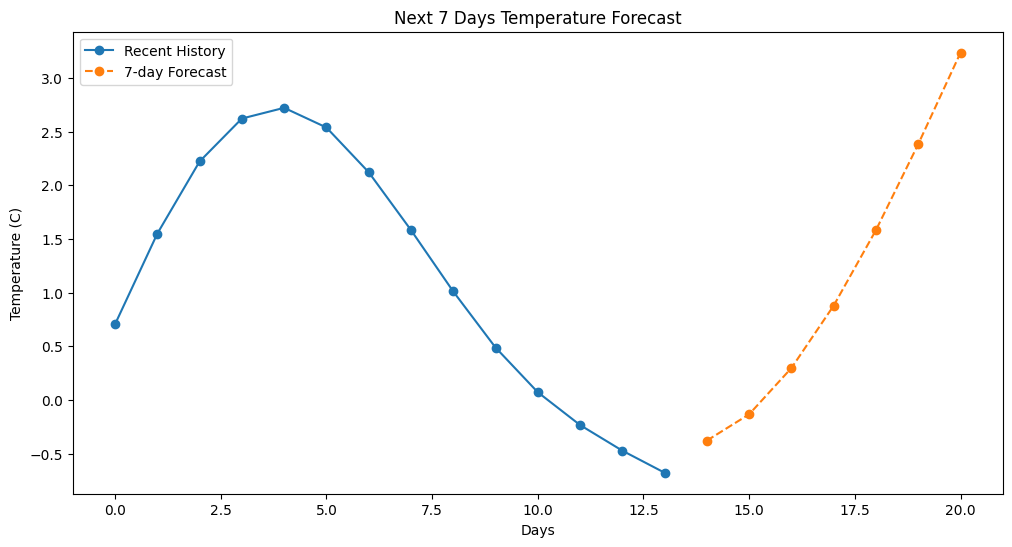

In [20]:
# -------------------------------
# 4. Plot forecast vs recent history
# -------------------------------
plt.figure(figsize=(12,6))
plt.plot(range(14), y_test_rescaled[-14:], label="Recent History", marker="o")
plt.plot(range(14, 21), forecast_rescaled, label="7-day Forecast", marker="o", linestyle="--")
plt.title("Next 7 Days Temperature Forecast")
plt.xlabel("Days")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()